<a href="https://colab.research.google.com/github/formesean/Tree-Image-Classifcation/blob/main/tree_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import needed libraries**

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

**Data Preparation**

In [82]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

# CIFAR-100 fine labels
cifar100_fine_labels = [
    "apple", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
    "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin",
    "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn mower", "leopard", "lion", "lizard", "lobster",
    "man", "maple", "motorcycle", "mountain", "mouse", "mushroom", "oak", "orange", "orchid", "otter", "palm", "pear", "pickup truck", "pine",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper",
    "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout",
    "tulip", "turtle", "wardrobe", "whale", "willow", "wolf", "woman", "worm"
]

# Define tree categories
tree_classes = ["maple", "oak", "palm", "pine", "willow"]
tree_indices = [cifar100_fine_labels.index(tree) for tree in tree_classes]

# Filter dataset for only tree images
mask_train = np.isin(y_train, tree_indices)

# Get the corresponding indices of the tree class
mask_test = np.isin(y_test, tree_indices)

# Extract only tree images and their labels
x_train_trees = x_train[mask_train.flatten()]
y_train_trees = y_train[mask_train.flatten()]
x_test_trees = x_test[mask_test.flatten()]
y_test_trees = y_test[mask_test.flatten()]

# Convert labels to 0-4 instead of original indexes
y_train_trees = np.array([tree_indices.index(label) for label in y_train_trees.flatten()])
y_test_trees = np.array([tree_indices.index(label) for label in y_test_trees.flatten()])

print(f"Training samples: {len(x_train_trees)}, Testing samples: {len(x_test_trees)}")

# Visualize labels
df = pd.DataFrame({
    "Index": np.arange(len(y_train_trees)),
    "Tree Class": [tree_classes[label] for label in y_train_trees]
})

print(df.head(10))

Training samples: 2500, Testing samples: 500
   Index Tree Class
0      0     willow
1      1       pine
2      2       pine
3      3        oak
4      4      maple
5      5       palm
6      6      maple
7      7      maple
8      8       palm
9      9       pine


**View an image**

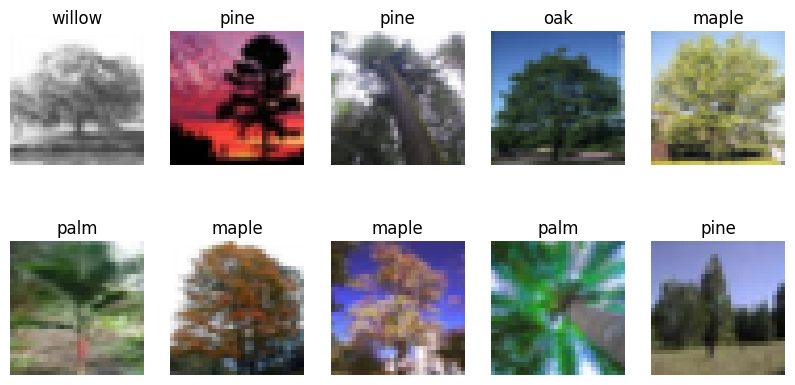

In [83]:
def plot_images(images, labels, classes, num=10):
    plt.figure(figsize=(10, 5))
    for i in range(num):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])           # Display image
        plt.title(classes[labels[i]])   # Display label
        plt.axis("off")
    plt.show()

plot_images(x_train_trees, y_train_trees, tree_classes, num=10)

**Preprocessing Images**

In [84]:
# Normalize images
x_train_trees = x_train_trees.astype("float32") / 255.0
x_test_trees = x_test_trees.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train_trees = to_categorical(y_train_trees, num_classes=5)
y_test_trees = to_categorical(y_test_trees, num_classes=5)

x_train_split, y_train_split, x_val_split, y_val_split = x_train_trees[:40000], y_train_trees[:40000], x_train_trees[40000:], y_train_trees[40000:]

# Augment image
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

**Build the CNN model**

In [85]:
model = Sequential([
    # Input layer
    Input(shape=(32, 32, 3)),

    # Hidden layer 1
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Hidden layer 2
    Conv2D(254, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Hidden layer 3
    Conv2D(254, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(254, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(5, activation='softmax')
])

# Display model architecture
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 254)         │         292,862 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 254)         │           1,016 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 8, 8, 254)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 254)           │         580,898 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 8, 8, 254)           │           1,016 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 254)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4064)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 254)                 │       1,032,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 254)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │           1,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,913,673 (7.30 MB)

 Trainable params: 1,912,401 (7.30 MB)

 Non-trainable params: 1,272 (4.97 KB)

**Compile the model**

In [86]:
model.compile(
    optimizer=Adam(learning_rate=0.0001, weight_decay=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Train model**

In [91]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

history = model.fit(
    datagen.flow(x_train_trees, y_train_trees, batch_size=64),
    epochs=25,
    validation_data=datagen.flow(x_train_trees, y_train_trees, batch_size=64),
    validation_split=0.2,
    callbacks=[reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5118 - loss: 1.2543 - val_accuracy: 0.3396 - val_loss: 1.5750 - learning_rate: 5.0000e-05
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5228 - loss: 1.2312 - val_accuracy: 0.3552 - val_loss: 1.6436 - learning_rate: 5.0000e-05
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5511 - loss: 1.1565 - val_accuracy: 0.3676 - val_loss: 1.6313 - learning_rate: 5.0000e-05
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5355 - loss: 1.1430 - val_accuracy: 0.4060 - val_loss: 1.5663 - learning_rate: 5.0000e-05
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5629 - loss: 1.1314 - val_accuracy: 0.4688 - val_loss: 1.4081 - learning_rate: 5.0000e-05
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5455 - loss: 1.1278 - val_accuracy: 0.4840 - val_loss: 1.2895 - learning_rate: 5.0000e-05
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5770 - loss:

**Evaluate the model on the test set**

In [88]:
test_loss, test_acc = model.evaluate(x_test_trees, y_test_trees)
print(f"\nTest Accuracy: {test_acc * 100:.4f}")
print(f"Test Loss: {test_loss * 100:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.4296 - loss: 1.3905

Test Accuracy: 41.0000
Test Loss: 140.9750


**Predict on Test Samples**

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step
Classification Report:
               precision    recall  f1-score   support

       maple     0.7200    0.1800    0.2880       100
         oak     0.5584    0.4300    0.4859       100
        palm     0.6349    0.4000    0.4908       100
        pine     0.4348    0.2000    0.2740       100
      willow     0.2907    0.8400    0.4319       100

    accuracy                         0.4100       500
   macro avg     0.5278    0.4100    0.3941       500
weighted avg     0.5278    0.4100    0.3941       500



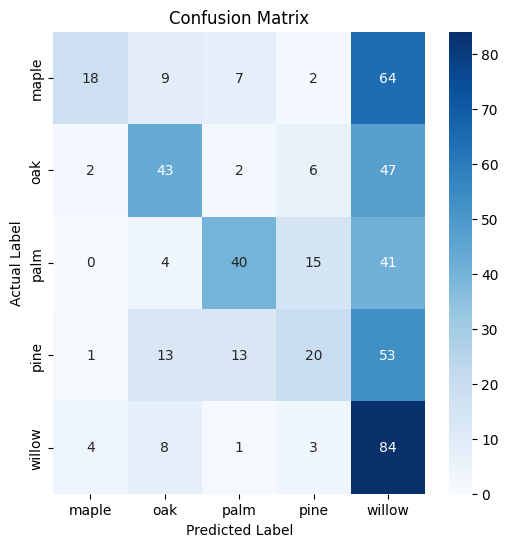

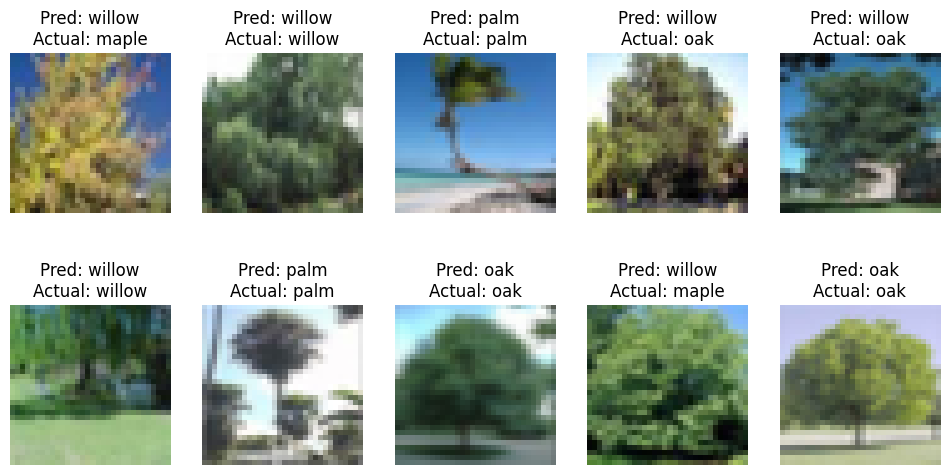

In [89]:
# Get predictions
predictions = model.predict(x_test_trees)

# Convert outputs to class labels
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_trees, axis=1)

# Calculate accuracy per class
report = classification_report(actual_classes, predicted_classes, target_names=tree_classes, digits=4)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=tree_classes, yticklabels=tree_classes)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Select random test samples
num_samples = 10
random_indices = np.random.choice(len(x_test_trees), num_samples, replace=False)

# Plot images with actual and predicted labels
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_trees[idx])
    plt.title(f"Pred: {tree_classes[predicted_classes[idx]]}\nActual: {tree_classes[actual_classes[idx]]}")
    plt.axis("off")

plt.show()


**Training Loss and Validation Loss**

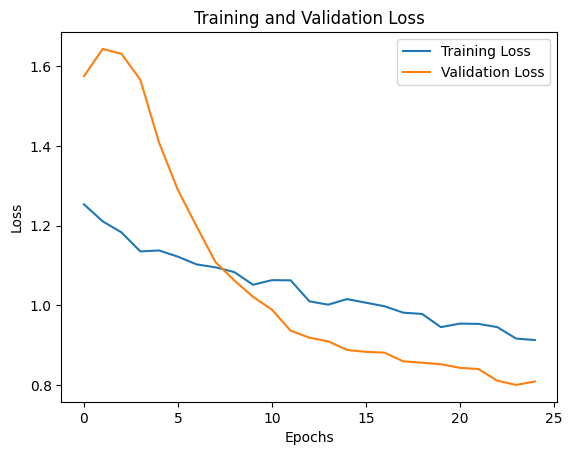

In [92]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()